In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac

In [2]:
from monk import nb, prep, pair, render, utils, grid
import freud

In [3]:
project: signac.Project = signac.get_project()

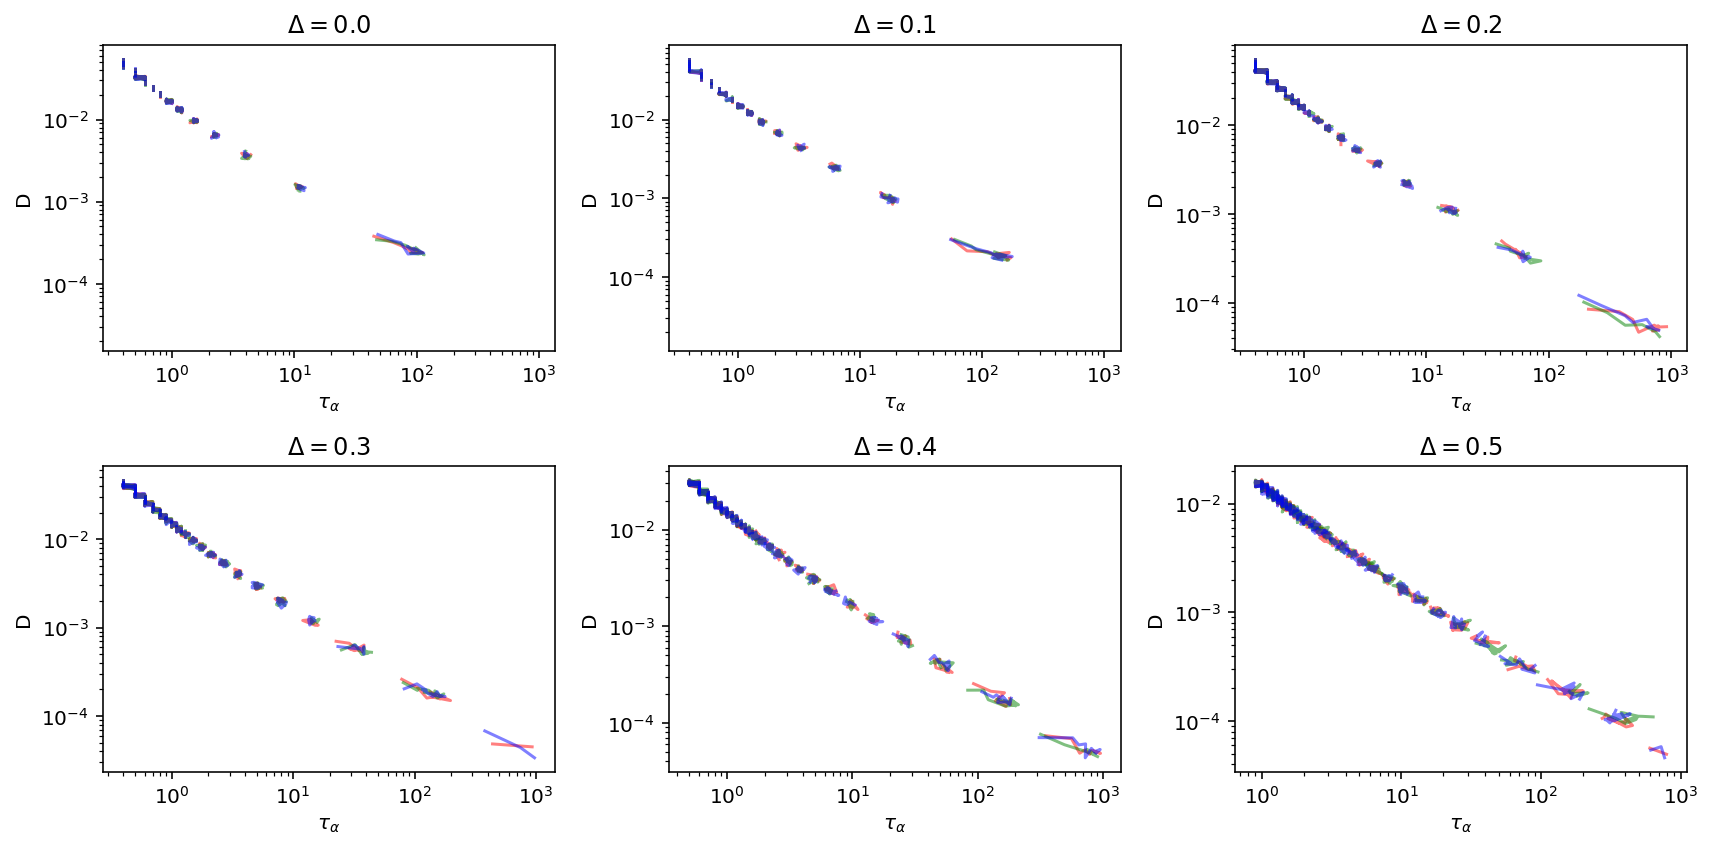

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)

faxs = axs.flatten()

_colors = ["r", "g", "b"]

for i, job in enumerate(sorted(list(project.__iter__()), key=lambda x: x.sp["seed"])):
    c_idx = job.sp["seed"]//6
    delta = job.sp["delta"]
    ax_idx = int(round(delta / 0.1))
    plt.sca(faxs[ax_idx])

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                alphas = job.data[f"{_temp_str}/alphas"][:]
                Ds = job.data[f"{_temp_str}/Ds"][:]
            plt.plot(alphas, Ds, color=_colors[c_idx], alpha=0.5)

    plt.title(rf"$\Delta={delta:.1f}$")
    plt.ylabel("D")
    plt.xlabel(r"$\tau_{\alpha}$")
    plt.yscale('log')
    plt.xscale('log')

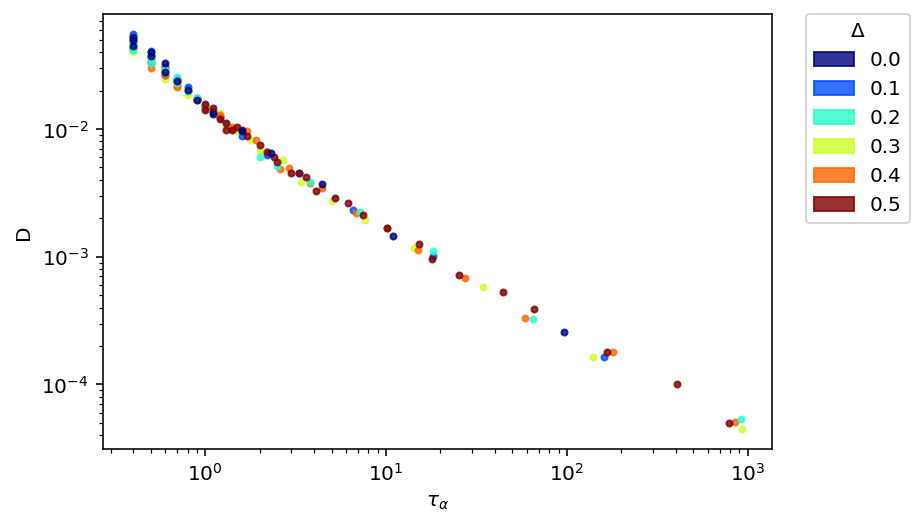

In [89]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            plt.plot(alphas, Ds, ".", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.ylabel("D")
plt.xlabel(r"$\tau_{\alpha}$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')
    

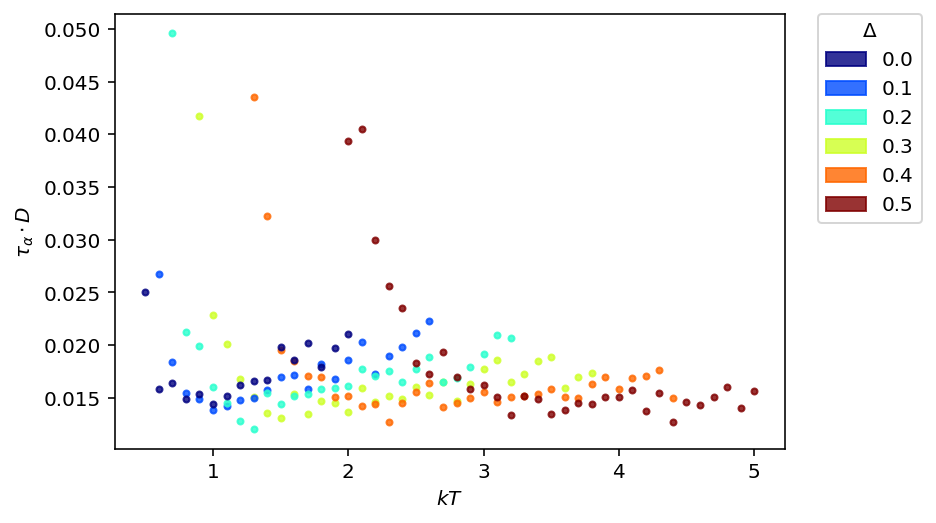

In [90]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            plt.plot(float(temp_str), alphas*Ds, ".", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$kT$")
plt.ylabel(r"$\tau_{\alpha} \cdot D$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   

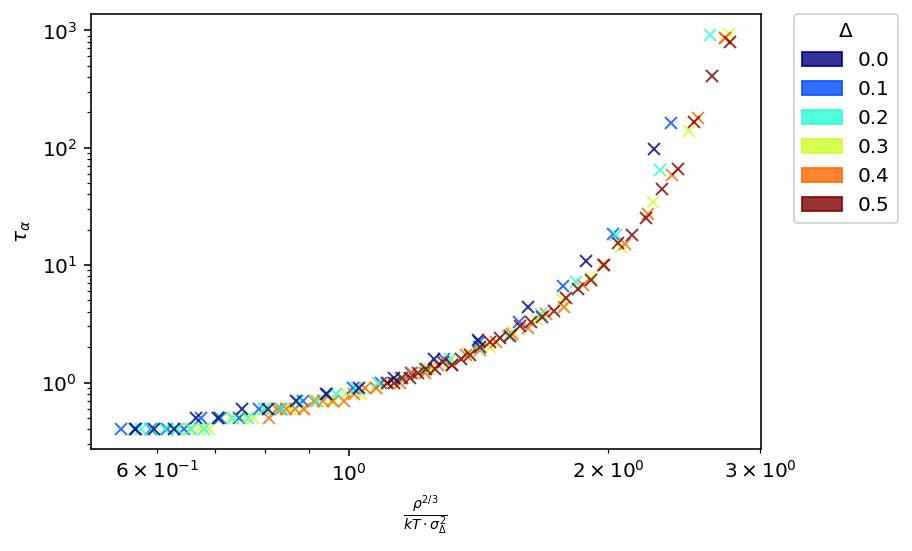

In [10]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

data_x = []
data_y = []

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    phi = job.sp["phi"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            x, y = 1/float(temp_str)*phi**(2/3)/(1 - delta*2**(1/6))**2, alphas
            data_x.append(x)
            data_y.append(y)
            plt.plot(1/float(temp_str)*phi**(2/3)/(1 - delta*2**(1/6))**2, alphas, "x", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$\frac{\rho^{2/3}}{kT \cdot \sigma_\Delta^2}$")
plt.ylabel(r"$\tau_\alpha$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')

data_x = np.array(data_x)
data_y = np.array(data_y)

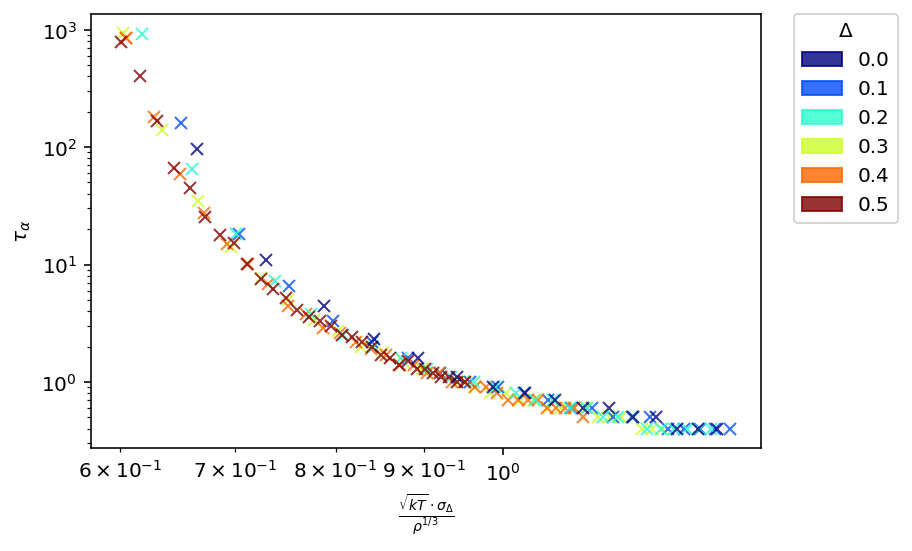

In [58]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

data_x = []
data_y = []

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    phi = job.sp["phi"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            x, y = np.sqrt(float(temp_str))/phi**(1/3)*(1 - delta*2**(1/6)), alphas
            data_x.append(x)
            data_y.append(y)
            plt.plot(np.sqrt(float(temp_str))/phi**(1/3)*(1 - delta*2**(1/6)), alphas, "x", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$\frac{\sqrt{kT} \cdot \sigma_\Delta}{\rho^{1/3}}$")
plt.ylabel(r"$\tau_\alpha$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')

data_x = np.array(data_x)
data_y = np.array(data_y)

In [11]:
from scipy.optimize import curve_fit

def log_vft(x, a, b, c) :
    return a + b /(1/x - c)

In [12]:
zip(*sorted(zip(data_x, data_y), key=lambda x: x[0]))

In [13]:
data_x[:4], data_y[:4]

(array([0.91876274, 2.75628823, 1.77189958, 2.06721617]),
 array([7.00000033e-01, 9.30000044e+02, 5.00000024e+00, 1.42000007e+01]))

Text(0, 0.5, '$\\tau_\\alpha$')

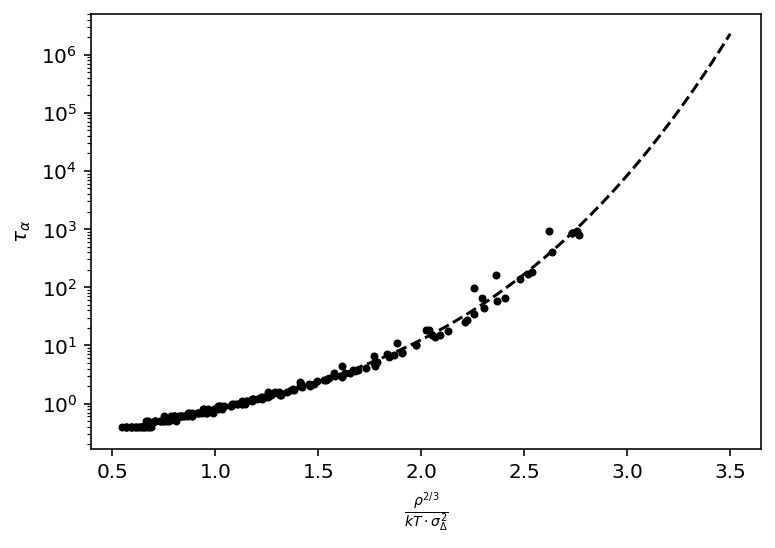

In [15]:
plt.plot(data_x, data_y, ".", color="k")
sx, sy = zip(*sorted(zip(data_x, data_y), key=lambda x: x[0]))

params = np.polyfit(data_x, np.log(data_y), 3)
# popt, pcov = curve_fit(temp_div_fit, sx, sy)
# fit_x = np.linspace(data_x.min(), data_x.max(), 100)
fit_x = np.linspace(sx[0], 3.5, 100)
# fit_y = temp_div_fit(fit_x, *popt)
fit_y = np.exp(np.polyval(params, fit_x))

plt.plot(fit_x, fit_y, "--", color="k")

plt.yscale('log')
# plt.xscale('log')

plt.xlabel(r"$\frac{\rho^{2/3}}{kT \cdot \sigma_\Delta^2}$")
plt.ylabel(r"$\tau_\alpha$")

In [25]:
def ka_alpha_est(T, phi, delta, min_clamp=1.0):
    # hardcoded fit parameters
    params = np.array([ 0.49717018, -1.0956471 ,  2.54414117, -2.15685159])
    x = np.exp(np.polyval(params, phi**(2/3)/(T*(1 - delta*2**(1/6))**2)))
    return np.clip(x, min_clamp, np.inf)

ka_alpha_est(0.41, 1.2, 0.0)

1018.9213055070264

Text(0, 0.5, '$\\tau_\\alpha$')

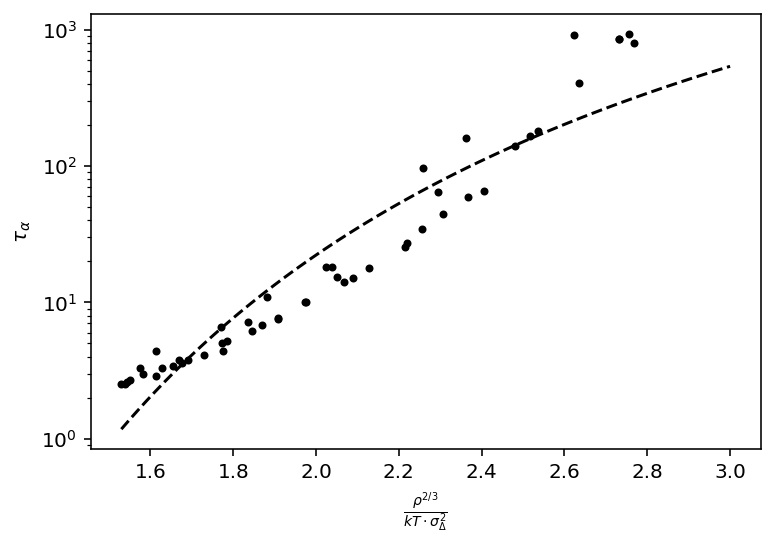

In [220]:

sx, sy = zip(*sorted(zip(data_x, data_y), key=lambda x: x[0]))
sx = np.array(sx)
sy = np.array(sy)
c = sx > 1.5
sx = sx[c]
sy = sy[c]

plt.plot(sx, sy, ".", color="k")

# params = np.polyfit(xy, np.log(data_y), 3)
popt, pcov = curve_fit(log_vft, sx, np.log(sy), maxfev=100000)
# fit_x = np.linspace(data_x.min(), data_x.max(), 100)
fit_x = np.linspace(sx[0], 3.0, 100)
fit_y = log_vft(fit_x, *popt)
# fit_y = np.exp(np.polyval(params, fit_x))

plt.plot(fit_x, np.exp(fit_y), "--", color="k")

plt.yscale('log')
# plt.xscale('log')

plt.xlabel(r"$\frac{\rho^{2/3}}{kT \cdot \sigma_\Delta^2}$")
plt.ylabel(r"$\tau_\alpha$")

In [210]:
popt

array([1.66326409e+04, 1.44664471e+07, 8.70424681e+02])

In [186]:
1.2**(2/3)/.41

2.7542517918469125

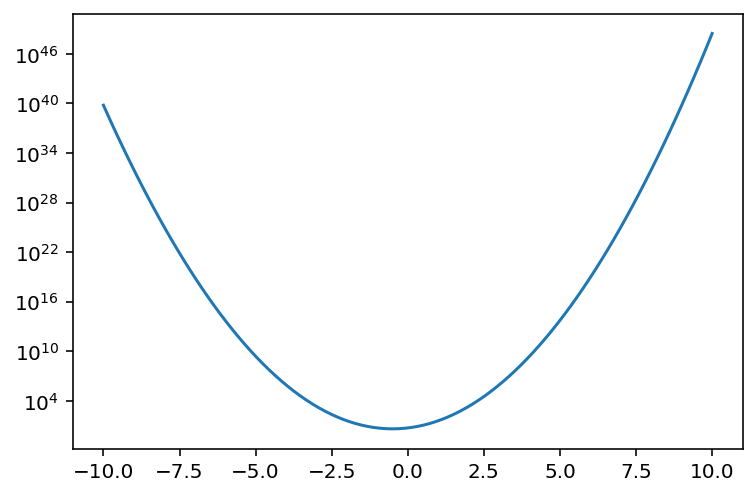

In [159]:
x = np.linspace(-10, 10, 100)
plt.plot(x, 5*np.exp(x + x**2))
plt.yscale('log')

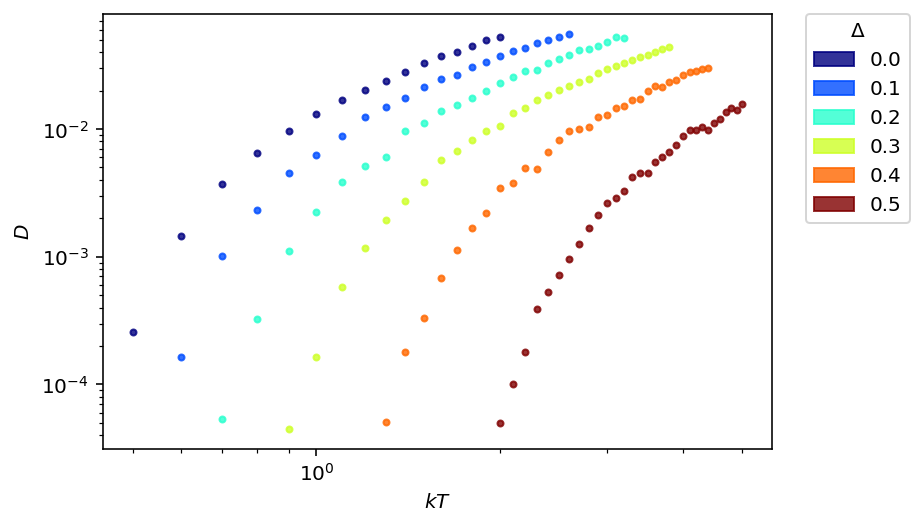

In [126]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    phi = job.sp["phi"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            plt.plot(float(temp_str), Ds, ".", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$kT$")
plt.ylabel(r"$D$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')

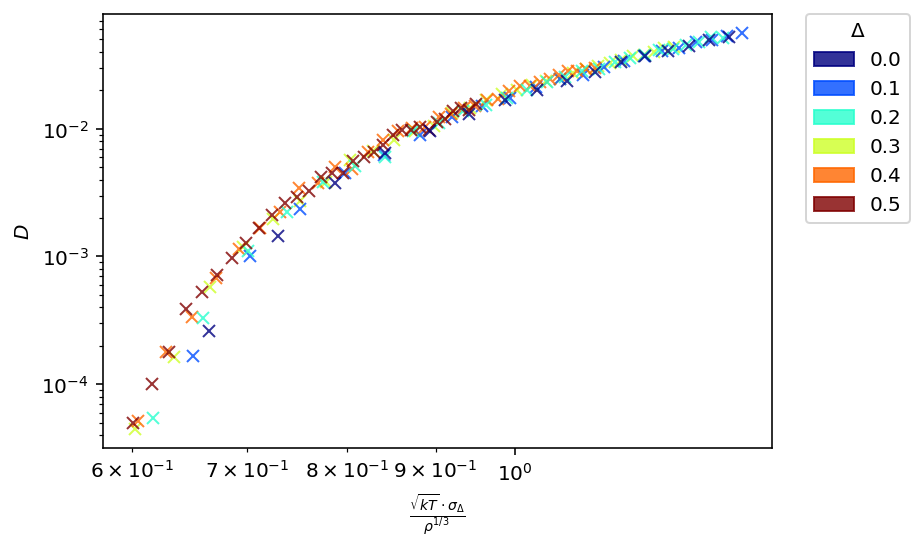

In [129]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    phi = job.sp["phi"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            plt.plot(np.sqrt(float(temp_str))/phi**(1/3)*(1 - delta*2**(1/6)), Ds, "x", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$\frac{\sqrt{kT} \cdot \sigma_\Delta}{\rho^{1/3}}$")
plt.ylabel(r"$D$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')

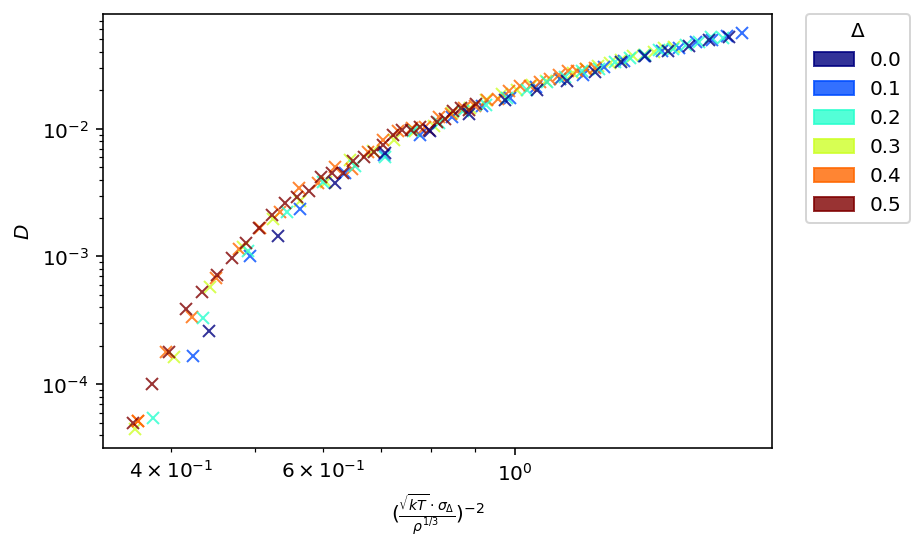

In [7]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    phi = job.sp["phi"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            plt.plot(np.square(np.sqrt(float(temp_str))/phi**(1/3)*(1 - delta*2**(1/6))), Ds, "x", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$(\frac{\sqrt{kT} \cdot \sigma_\Delta}{\rho^{1/3}})^{-2}$")
plt.ylabel(r"$D$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')

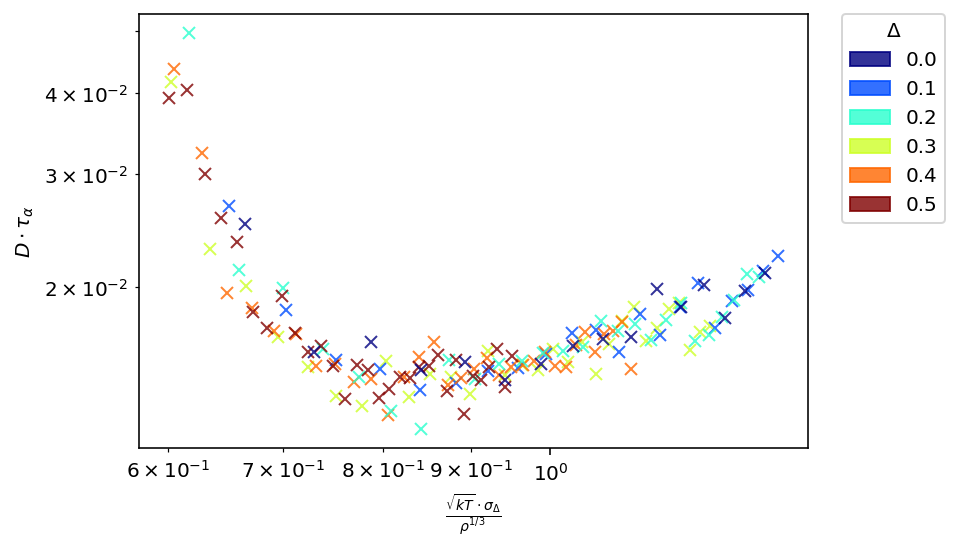

In [130]:

plt.figure()

alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=5)
_colors = [cmap(norm(i)) for i in range(6)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    phi = job.sp["phi"]

    with job:
        sims = glob.glob("*equil_*.gsd")
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alphas = job.data[f"{_temp_str}/alphas"][-1]
                Ds = job.data[f"{_temp_str}/Ds"][-1]
            plt.plot(np.sqrt(float(temp_str))/phi**(1/3)*(1 - delta*2**(1/6)), Ds*alphas, "x", color=_colors[int(round(delta / 0.1))], alpha=alpha)

plt.xlabel(r"$\frac{\sqrt{kT} \cdot \sigma_\Delta}{\rho^{1/3}}$")
plt.ylabel(r"$D \cdot \tau_\alpha$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.yscale('log')
plt.xscale('log')

In [5]:
def iso_mlj_pred(T, delta, phi):
    """Find temperature with equivalent dynamics to ref MLJ system (delta=0.0, phi=1.2)"""
    return T * (phi/1.2)**(2/3) / (1 - delta*2**(1/6))**2

In [6]:
iso_mlj_pred(0.45, 0.5, 1.1)

2.2057095087510827

In [180]:
new_sim_temps = np.array([0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

In [181]:
len(new_sim_temps)

22

In [182]:
systems = [[0.0, 1.2], [0.1, 1.18], [0.2, 1.16], [0.3, 1.14], [0.4, 1.12], [0.5, 1.1]]
for delta, phi in systems:
    for t in iso_mlj_pred(new_sim_temps, delta, phi):
        print(f"{t:.2f} ", end="")
    print()

0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55 0.58 0.61 0.64 0.67 0.70 0.75 0.80 0.90 1.00 1.20 1.40 1.60 1.80 2.00 
0.51 0.54 0.56 0.59 0.61 0.64 0.67 0.69 0.73 0.77 0.80 0.84 0.88 0.94 1.00 1.13 1.25 1.51 1.76 2.01 2.26 2.51 
0.67 0.70 0.73 0.76 0.80 0.83 0.86 0.89 0.94 0.99 1.04 1.09 1.14 1.22 1.30 1.46 1.63 1.95 2.28 2.60 2.93 3.25 
0.90 0.94 0.99 1.03 1.08 1.12 1.16 1.21 1.27 1.34 1.41 1.47 1.54 1.65 1.76 1.98 2.20 2.64 3.08 3.51 3.95 4.39 
1.29 1.35 1.42 1.48 1.54 1.60 1.67 1.73 1.82 1.92 2.01 2.11 2.20 2.36 2.52 2.83 3.15 3.77 4.40 5.03 5.66 6.29 
2.01 2.11 2.21 2.30 2.40 2.50 2.60 2.70 2.84 2.99 3.14 3.28 3.43 3.68 3.92 4.41 4.90 5.88 6.86 7.84 8.82 9.80 
